In [23]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
pd.set_option('display.max_columns', None)

In [25]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    },
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [26]:
agg_strats = ['min','max']
#agg_strats = ['mean']


m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

KeyError: "['cloud_base_agl:m_-1h', 'cloud_base_agl:m_1h', 'GHI_lag_-1h', 'GHI_lag_1h', 'temp*GHI_lag_-1h', 'temp*GHI_lag_1h', 'effective_cloud_cover:p_-1h', 'effective_cloud_cover:p_1h'] not in index"

In [ ]:
# get data
# X_train, y_train = m_wrap.get_train(aggregated=False,drop_val=True,drop_test=False)
# X_val, y_val = m_wrap.get_val(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)
# X_sub = m_wrap.get_sub(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)


X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
#X_val_agg, y_val_agg = m_wrap.get_val(aggregated=True)
X_test_agg, y_test_agg = m_wrap.get_test(aggregated=True,y_scaled=False)
X_sub_agg = m_wrap.get_sub(aggregated=True)

y_train_agg.loc[y_train_agg>4000] *= 1.05

In [ ]:
# exclude datetime columns
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])
#X_val_agg = X_val_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")

categorical_features: ['building_id']
impute_features: []


In [ ]:
MAEs = []

for i in range(5):
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )


    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=8,
        random_seed=i*10,
    )

    open('status.csv', 'w').close()
    # build the pipeline
    mod_pipe = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('statusSaver', StatusSaver()),
        ('estimator', mod)
    ])

    mod_pipe.fit(X_train_agg, y_train_agg)

    pred = pd.Series(mod_pipe.predict(X_test_agg))

    mae = m_wrap.get_mae(pred,X_test_agg, y_test_agg, is_aggregated=True)
    print(f'MAE: {mae}')
    MAEs.append(mae)

MAEs = np.array(MAEs)

0:	learn: 0.1476446	total: 20ms	remaining: 16s
1:	learn: 0.1438715	total: 39.1ms	remaining: 15.6s
2:	learn: 0.1400036	total: 56ms	remaining: 14.9s
3:	learn: 0.1365514	total: 73ms	remaining: 14.5s
4:	learn: 0.1332392	total: 92.1ms	remaining: 14.7s
5:	learn: 0.1303212	total: 110ms	remaining: 14.6s
6:	learn: 0.1269901	total: 128ms	remaining: 14.5s
7:	learn: 0.1242802	total: 180ms	remaining: 17.8s
8:	learn: 0.1213037	total: 203ms	remaining: 17.8s
9:	learn: 0.1182591	total: 221ms	remaining: 17.5s
10:	learn: 0.1153774	total: 241ms	remaining: 17.3s
11:	learn: 0.1126890	total: 264ms	remaining: 17.3s
12:	learn: 0.1100529	total: 281ms	remaining: 17s
13:	learn: 0.1075800	total: 301ms	remaining: 16.9s
14:	learn: 0.1051813	total: 319ms	remaining: 16.7s
15:	learn: 0.1031504	total: 339ms	remaining: 16.6s
16:	learn: 0.1009613	total: 356ms	remaining: 16.4s
17:	learn: 0.0987647	total: 374ms	remaining: 16.3s
18:	learn: 0.0967741	total: 393ms	remaining: 16.1s
19:	learn: 0.0946780	total: 411ms	remaining: 1

<Axes: ylabel='pv_measurement'>

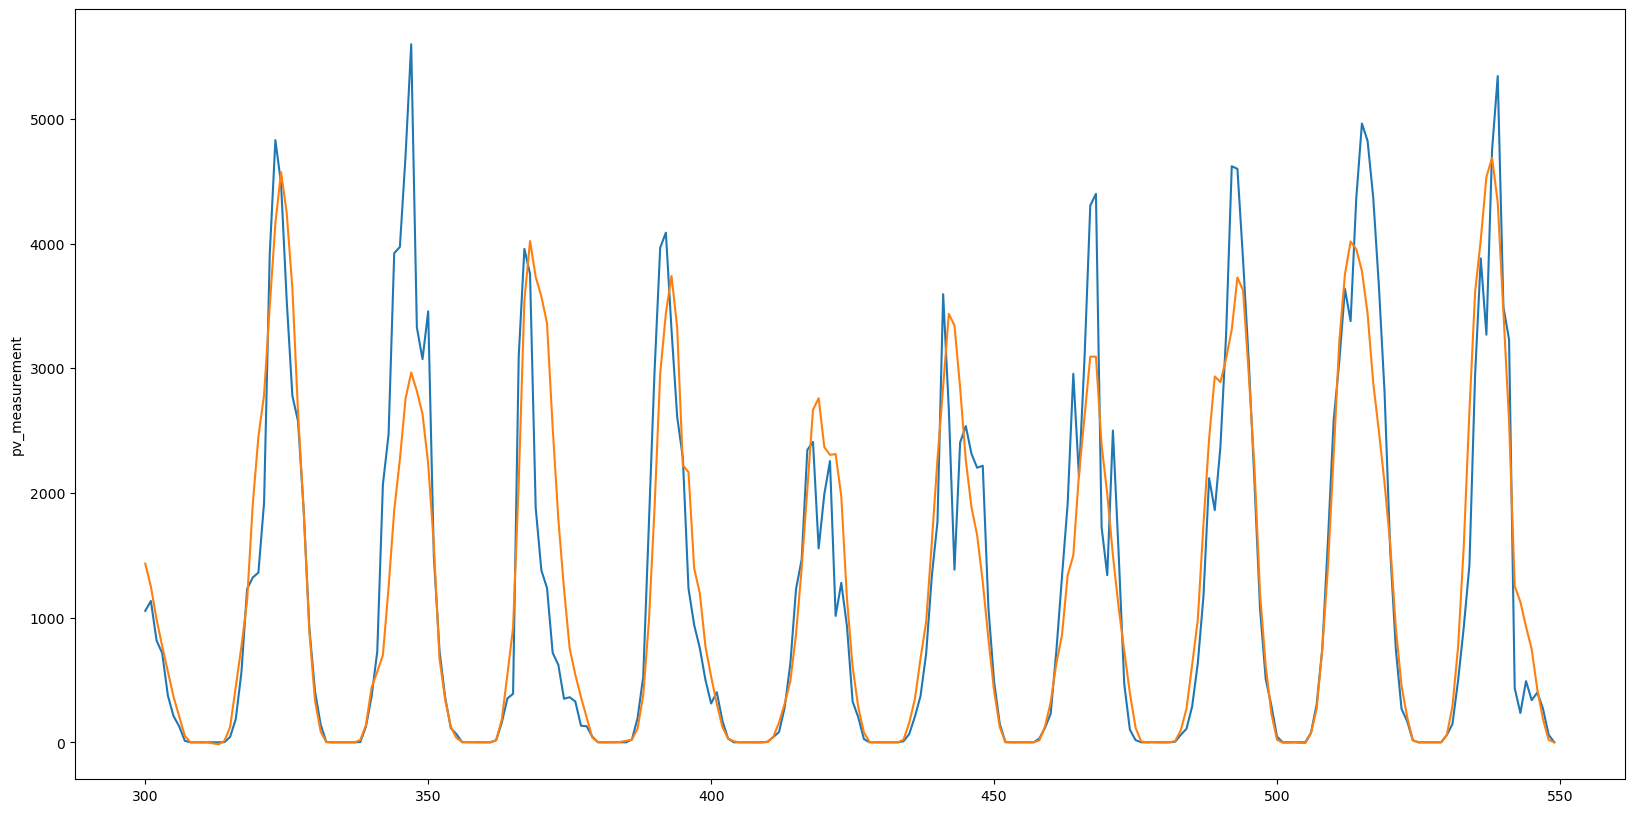

In [ ]:
#scale predictions

y_scaled = m_wrap.y_scalers[0].inverse_transform(pred,X_test_agg)

start_index = 300
end_index = start_index + 250
plt.figure(figsize=(20,10))
sns.lineplot(x=y_test_agg[start_index:end_index].index,y=y_test_agg[start_index:end_index])
sns.lineplot(x=y_test_agg[start_index:end_index].index,y=y_scaled[start_index:end_index])

MAEs: [141.68657039 142.47455395 142.63336561 142.95931768 143.35237775]
MAE mean: 142.62123707617837


<Axes: >

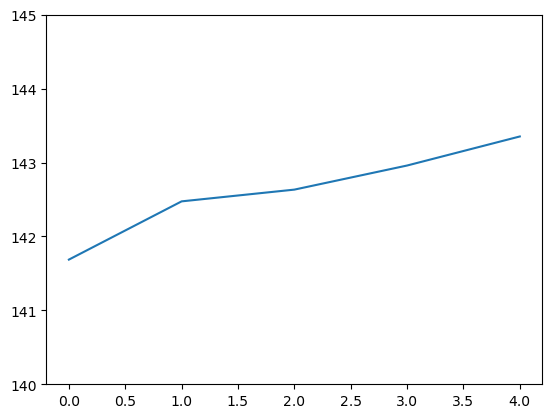

In [ ]:
# sort maes
MAEs.sort()

print(f"MAEs: {MAEs}")
print(f"MAE mean: {np.mean(MAEs)}")

plt.ylim(140,145)
sns.lineplot(x=range(len(MAEs)),y=MAEs)

In [ ]:
X_test_agg

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,min_absolute_humidity_2m:gm3,min_air_density_2m:kgm3,min_ceiling_height_agl:m,min_clear_sky_energy_1h:J,min_clear_sky_rad:W,min_cloud_base_agl:m,min_dew_or_rime:idx,min_dew_point_2m:K,min_diffuse_rad:W,min_diffuse_rad_1h:J,min_direct_rad:W,min_direct_rad_1h:J,min_effective_cloud_cover:p,min_is_day:idx,min_is_in_shadow:idx,min_msl_pressure:hPa,min_precip_5min:mm,min_precip_type_5min:idx,min_pressure_100m:hPa,min_pressure_50m:hPa,min_prob_rime:p,min_rain_water:kgm2,min_relative_humidity_1000hPa:p,min_sfc_pressure:hPa,min_sun_azimuth:d,min_sun_elevation:d,min_super_cooled_liquid_water:kgm2,min_t_1000hPa:K,min_total_cloud_cover:p,min_visibility:m,min_wind_speed_10m:ms,min_wind_speed_u_10m:ms,min_wind_speed_v_10m:ms,min_wind_speed_w_1000hPa:ms,min_date_calc,min_GHI,min_wind_angle,min_temp*GHI,min_wind*humidity,min_sun_height*diff_rad,min_wind_angle_sin,min_wind_angle_cos,min_hour_sin,min_hour_cos,min_GHI_daily_mean,min_GHI_daily_std,min_effective_cloud_cover_5h_mean,min_GHI_lag_-1h,min_GHI_lag_1h,min_temp*GHI_lag_-1h,min_temp*GHI_lag_1h,min_effective_cloud_cover:p_-1h,min_effective_cloud_cover:p_1h,min_cloud_base_agl:m_-1h,min_cloud_base_agl:m_1h,max_absolute_humidity_2m:gm3,max_air_density_2m:kgm3,max_ceiling_height_agl:m,max_clear_sky_energy_1h:J,max_clear_sky_rad:W,max_cloud_base_agl:m,max_dew_or_rime:idx,max_dew_point_2m:K,max_diffuse_rad:W,max_diffuse_rad_1h:J,max_direct_rad:W,max_direct_rad_1h:J,max_effective_cloud_cover:p,max_is_day:idx,max_is_in_shadow:idx,max_msl_pressure:hPa,max_precip_5min:mm,max_precip_type_5min:idx,max_pressure_100m:hPa,max_pressure_50m:hPa,max_prob_rime:p,max_rain_water:kgm2,max_relative_humidity_1000hPa:p,max_sfc_pressure:hPa,max_sun_azimuth:d,max_sun_elevation:d,max_super_cooled_liquid_water:kgm2,max_t_1000hPa:K,max_total_cloud_cover:p,max_visibility:m,max_wind_speed_10m:ms,max_wind_speed_u_10m:ms,max_wind_speed_v_10m:ms,max_wind_speed_w_1000hPa:ms,max_date_calc,max_GHI,max_wind_angle,max_temp*GHI,max_wind*humidity,max_sun_height*diff_rad,max_wind_angle_sin,max_wind_angle_cos,max_hour_sin,max_hour_cos,max_GHI_daily_mean,max_GHI_daily_std,max_effective_cloud_cover_5h_mean,max_GHI_lag_-1h,max_GHI_lag_1h,max_temp*GHI_lag_-1h,max_temp*GHI_lag_1h,max_effective_cloud_cover:p_-1h,max_effective_cloud_cover:p_1h,max_cloud_base_agl:m_-1h,max_cloud_base_agl:m_1h
0,a,2021-05-01 00:00:00,0,0.0,2021-05-01 00:00:00,2021-05-01,2021-05,5,0,4.7,1.288,2263.399902,0.000000,0.000000,368.299988,0.0,272.700012,0.0,0.000000,0.0,0.000000,75.000000,0.0,1.0,1016.500000,0.0,0.0,1003.299988,1009.599976,0.0,0.0,85.699997,1015.900024,10.054000,-11.075,0.0,274.000000,75.000000,16799.400391,1.7,1.7,0.3,-0.0,NaT,0.0,1.325818,0.000000,145.690002,-0.000000,0.970142,1.737853e-01,0.000000,1.000000,189.842712,206.237961,78.755,0.000000,0.000000,0.000000,0.000000,87.800003,72.300003,366.600006,400.399994,4.8,1.288,2263.399902,0.000000,0.000000,399.500000,0.0,273.000000,0.0,0.000000,0.0,0.000000,84.900002,0.0,1.0,1016.700012,0.0,0.0,1003.599976,1009.799988,0.0,0.0,86.800003,1016.099976,21.042000,-9.724,0.1,274.200012,85.099998,16991.199219,2.1,2.0,0.5,-0.0,NaT,0.000000,1.396124,0.000000,182.279999,-0.000000,0.984784,2.425356e-01,0.000000,1.000000,189.842712,206.237961,83.985,0.000000,0.000000,0.000000,0.000000,96.500000,74.199997,409.899994,496.700012
1,a,2021-05-01 01:00:00,0,0.0,2021-05-01 01:00:00,2021-05-01,2021-05,5,1,4.6,1.287,1079.400024,0.000000,0.000000,366.600006,0.0,272.500000,0.0,0.000000,0.0,0.000000,87.800003,0.0,1.0,1016.799988,0.0,0.0,1003.599976,1009.900024,0.0,0.0,85.300003,1016.200012,24.662001,-9.071,0.1,273.899994,87.900002,17086.199219,1.6,1.6,0.2,-0.0,NaT,0.0,1.325818,0.000000,136.480011,-0.000000,0.970142,1.240348e-01,0.258819,0.965926,189.842712,206.237961,85.530,0.000000,0.000000,0.000000,0.000000,97.900002,75.000000,342.799988,368.299988,4.6,1.288,2263.399902,0.000000,0.000000,409.899994,0.0,272.600006,0.0,0.0

In [ ]:
err

NameError: name 'err' is not defined

In [ ]:
# gs.best_params_

In [ ]:
model = mod_pipe#gs.best_estimator_

In [ ]:
# get val scores
# sns.lineplot(gs.cv_results_['mean_test_score'])

In [ ]:
# for key, values in gs.param_grid.items():
#     pass

# plt.figure(figsize=(20, 5))
# # plt.ylim(0.05, 0.0525)
# sns.lineplot(y=gs.cv_results_['mean_test_MAE']*-1, x=list(map(str, values)))
# plt.xticks(rotation=90);

# plt.figure(figsize=(20, 5))
# sns.lineplot(y=gs.cv_results_['mean_test_STD']*-1, x=list(map(str, values)))
# plt.xticks(rotation=90);

MAE: 143.02005295063796


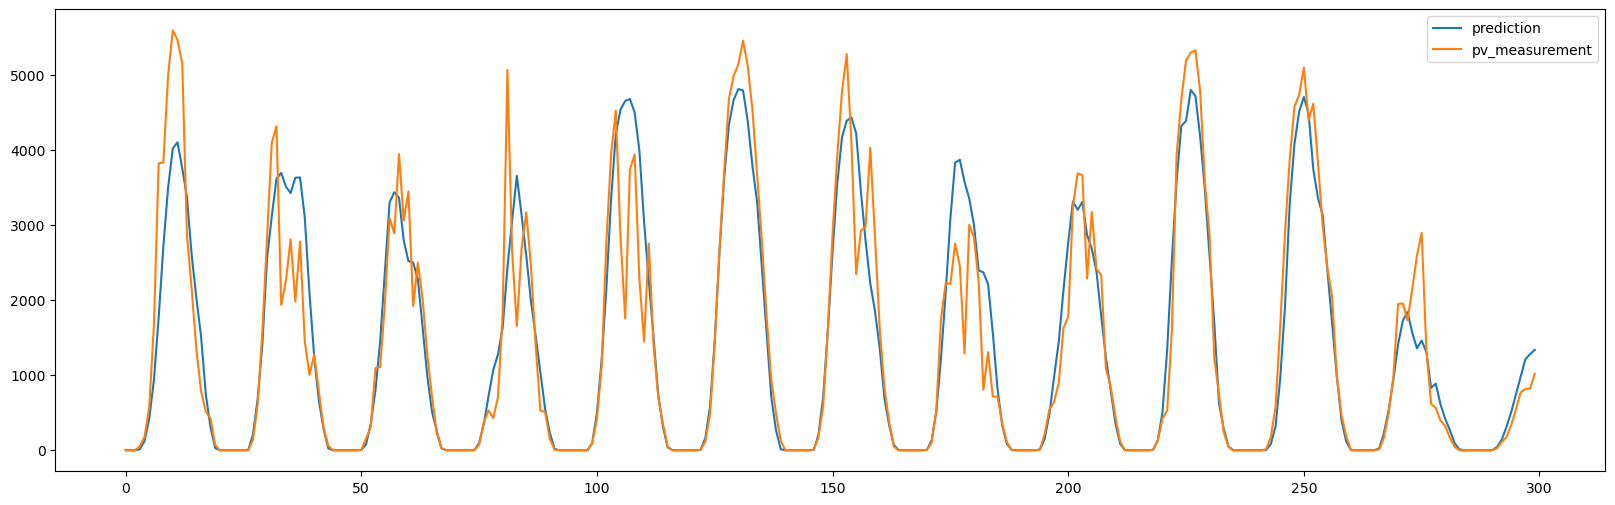

In [ ]:
m_wrap.plot_Pred_vs_PV(pred,y_test_agg,X_test_agg,start_idx=0,end_idx=300)

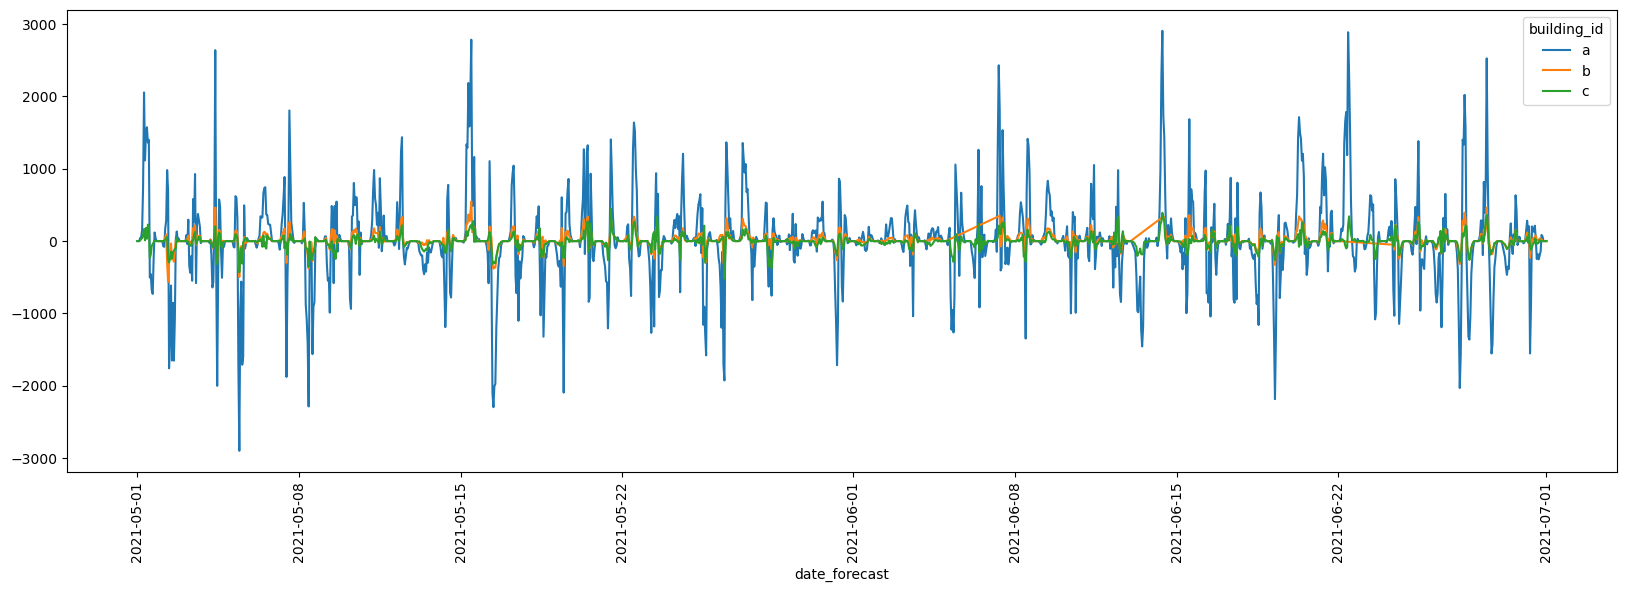

In [ ]:
m_wrap.plot_Residuals(pred,y_test_agg,X_test_agg)

In [ ]:
model

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['delta_forecast',
                                                   'min_ceiling_height_agl:m',
                                                   'min_cloud_base_agl:m',
                                                   'min_snow_density:kgm3',
                                                   'min_effective_cloud_cover_5h_mean',
                                                   'min_GHI_lag_-1h',
                                                   'min_GHI_lag_1h',
                                                   'min_temp*GHI_lag_-1h',
                                                   'min_temp*GHI_l...
                                                   'max_ceiling_height_agl:m',
                                                   'max_cloud_base_agl:m',
                                                   'max_snow_density:kgm3',
                                                   'max_effective_cloud_cover_5h_mean',
                                                   'max_GHI_lag_-1h',
                                                   'max_GHI_lag_1h',
                                                   'max_temp*GHI_lag_-1h',
                                                   'max_temp*GHI_lag_1h']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['building_id'])])),
                ('statusSaver', StatusSaver()),
                ('estimator',
                 <catboost.core.CatBoostRegressor object at 0x29eee77d0>)])

In [ ]:
X_all, y_all = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_all = X_all.select_dtypes(exclude=['datetime','timedelta','period[M]'])

model.fit(X_all, y_all)

0:	learn: 0.1545581	total: 19.7ms	remaining: 15.7s
1:	learn: 0.1507532	total: 36.9ms	remaining: 14.7s
2:	learn: 0.1471160	total: 58.3ms	remaining: 15.5s
3:	learn: 0.1432983	total: 74.7ms	remaining: 14.9s
4:	learn: 0.1395582	total: 91.4ms	remaining: 14.5s
5:	learn: 0.1359937	total: 109ms	remaining: 14.5s
6:	learn: 0.1327512	total: 126ms	remaining: 14.3s
7:	learn: 0.1295188	total: 142ms	remaining: 14s
8:	learn: 0.1262082	total: 157ms	remaining: 13.8s
9:	learn: 0.1230312	total: 174ms	remaining: 13.7s
10:	learn: 0.1200834	total: 191ms	remaining: 13.7s
11:	learn: 0.1173085	total: 207ms	remaining: 13.6s
12:	learn: 0.1145436	total: 223ms	remaining: 13.5s
13:	learn: 0.1120606	total: 242ms	remaining: 13.6s
14:	learn: 0.1094457	total: 259ms	remaining: 13.5s
15:	learn: 0.1071279	total: 276ms	remaining: 13.5s
16:	learn: 0.1048403	total: 297ms	remaining: 13.7s
17:	learn: 0.1024706	total: 313ms	remaining: 13.6s
18:	learn: 0.1001557	total: 330ms	remaining: 13.6s
19:	learn: 0.0979888	total: 350ms	rema

In [ ]:
pred_sub = pd.Series(model.predict(X_sub_agg))
m_wrap.y_pred_to_csv(pred_sub, X_sub_agg, is_aggregated=True,name='catboost_all.csv',sun_el_thr=1)

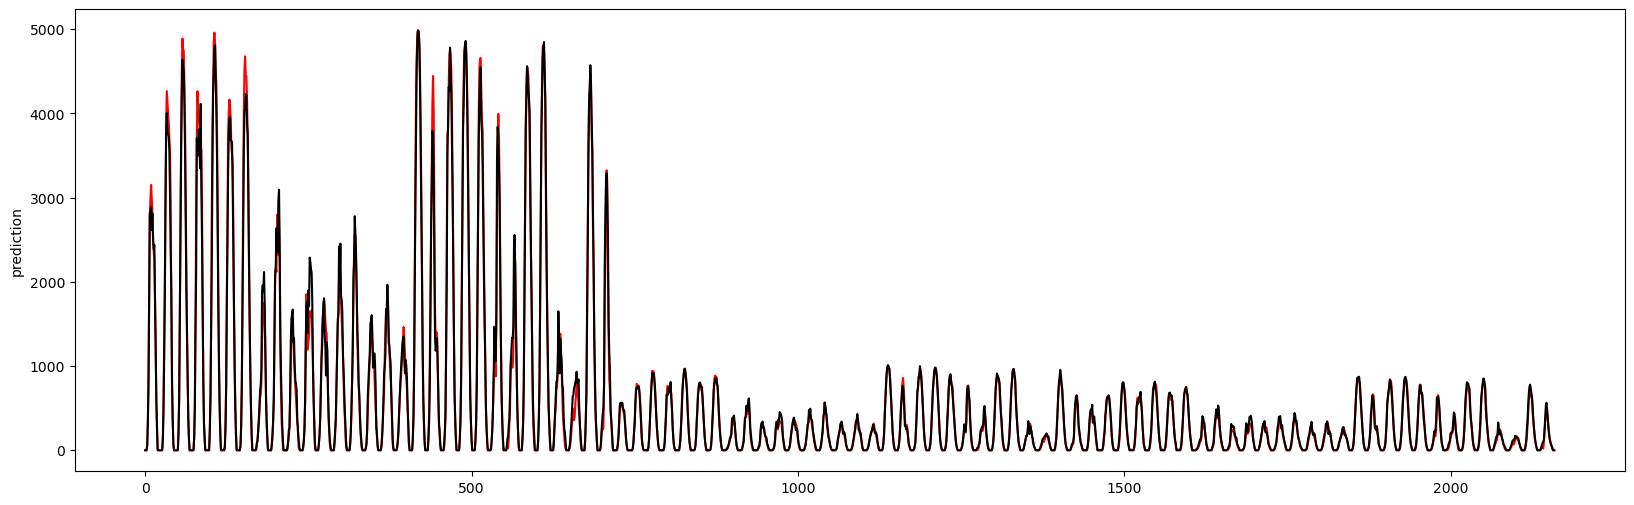

In [ ]:
m_wrap.plot_yPredSub_vs_submission(pred_sub,X_sub_agg,sub_file='./submission_files/152_029_xgboost.csv')